# Sub-FOV Scan-phase

In [2]:
import masknmf
from pathlib import Path
import fastplotlib as fpl
import tifffile
import numpy as np
import matplotlib.pyplot as plt

try:
    import mbo_utilities as mbo
except ImportError:
    print("uv pip install git+https://github.com/MillerBrainObservatory/mbo_utilities.git@dev")
    
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

from mbo_utilities import log

In [15]:
raw_files = [x for x in Path(r"D:\tests_bigmem\roi2").glob("*.tif*")]
data_store = {}

for file in raw_files:
    data_store[file.stem] = tifffile.memmap(file)

In [13]:
data_store.keys()

dict_keys(['plane10', 'plane5', 'plane6', 'plane7', 'plane8', 'plane9'])

In [14]:
zplane_name = "plane9"

data = data_store[zplane_name]

In [22]:
offsets = np.array([_phase_corr_2d(frame, 10) for frame in data])

In [30]:
np.min(offsets)

np.float64(-0.9)

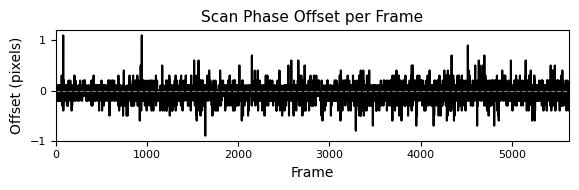

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(offsets, lw=1.5, color="black")
ax.axhline(0, color="gray", linestyle="--", lw=0.8)
ax.set_xlabel("Frame", fontsize=10)
ax.set_ylabel("Offset (pixels)", fontsize=10)
ax.set_xlim(0, len(offsets) - 1)
ax.tick_params(labelsize=8)
ax.set_title("Scan Phase Offset per Frame", fontsize=11)
fig.tight_layout()

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation

from mbo_utilities.phasecorr import _phase_corr_2d

def phase_offsets_timecourse(data, n_parts=3, upsample=10, max_offset=4, border=0):
    t, h, w = data.shape
    xsplits = np.linspace(0, w, n_parts + 1, dtype=int)
    offsets = []

    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        patch_offsets = [_phase_corr_2d(frame[:, x0:x1], upsample, max_offset=max_offset, border=border)for frame in data]
        offsets.append(patch_offsets)

    return xsplits, np.array(offsets) 


In [187]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

upsample = 10
max_offset = 4
border = 0

mean_img = data.mean(0).astype(np.float32)
xsplits, offsets = phase_offsets_timecourse(data, n_parts=6, upsample=upsample, max_offset=max_offset, border=border)
n_parts, n_frames = offsets.shape

# Get global y-axis limits across all patches
all_y = np.concatenate(offsets)
ymin, ymax = all_y.min(), all_y.max()
pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad


In [194]:
def compute_phase_offsets(data, n_parts=10, upsample=10, max_offset=4, border=0):
    return phase_offsets_timecourse(data, n_parts=n_parts, upsample=upsample, max_offset=max_offset, border=border)

def plot_phase_offsets(mean_img, xsplits, offsets, upsample, max_offset, border, title_prefix="", save_path=None):
    n_parts, n_frames = offsets.shape
    all_y = np.concatenate(offsets)
    ymin, ymax = all_y.min(), all_y.max()
    pad = 0.05 * (ymax - ymin)
    ymin -= pad
    ymax += pad

    fig = plt.figure(figsize=(10, 1.5 * n_parts), constrained_layout=True)
    fig.suptitle(f"{title_prefix}Per-Frame Offsets (1/{upsample} px precision) | max shift={max_offset}px, border={border}px",
                 fontsize=14, y=0.94)

    outer = GridSpec(1, 2, width_ratios=[1.2, 2], wspace=0.2)

    ax_img = fig.add_subplot(outer[0, 0])
    ax_img.imshow(mean_img, cmap="gray")
    h, w = mean_img.shape
    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        center_x = (x0 + x1) / 2
        rect = plt.Rectangle((x0, 0), x1 - x0, h, edgecolor="red", facecolor="none", linewidth=1.5)
        ax_img.add_patch(rect)
        ax_img.text(center_x, h - 10, f"{i+1}", color='w', fontsize=12, weight="bold", ha="center", va="center")
    ax_img.set_title("Sub-FOVs", fontsize=12)
    ax_img.axis("off")

    inner = GridSpecFromSubplotSpec(n_parts, 1, subplot_spec=outer[0, 1], hspace=0.05)
    for i in range(n_parts):
        ax = fig.add_subplot(inner[i])
        y = offsets[i]
        x = np.arange(len(y))
        ax.plot(x, y, color="black", lw=0.3)
        slope, intercept = np.polyfit(x, y, deg=1)
        fit = slope * x + intercept
        ax.plot(x, fit, color="red", linestyle="--", linewidth=1)
        ax.set_ylim(ymin, ymax)
        ax.axhline(0, color="gray", linestyle="--", lw=0.8)
        ax.set_ylabel(f"{i + 1}", fontsize=9, weight="bold", rotation=0, labelpad=15)
        ax.spines[:].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False, right=False)
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=(i == n_parts - 1))
        if i == n_parts - 1:
            ax.set_xlabel("Frame", fontsize=10)

    if save_path:
        fig.savefig(save_path, dpi=150)
    plt.show()

def run_plot_for_plane(data, plane_name, save_dir=None, **kwargs):
    mean_img = data.mean(0).astype(np.float32)
    xsplits, offsets = compute_phase_offsets(data, **kwargs)
    if save_dir:
        Path(save_dir).mkdir(exist_ok=True)
        save_path = Path(save_dir) / f"{plane_name}_offset_plot.png"
    else:
        save_path = None
    plot_phase_offsets(mean_img, xsplits, offsets, upsample=kwargs["upsample"], max_offset=kwargs["max_offset"], border=kwargs["border"],
                   title_prefix=f"{plane_name} | ", save_path=save_path)



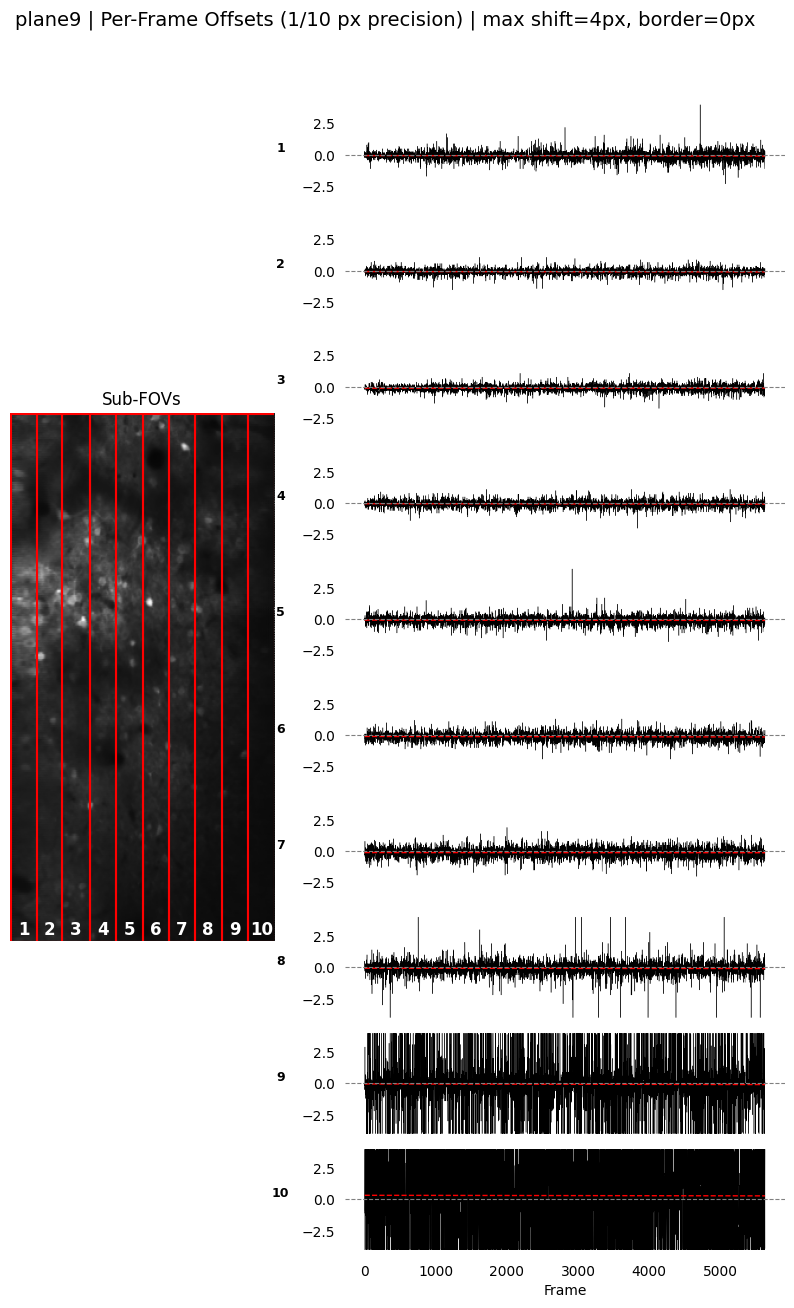

In [184]:
run_plot_for_plane(data_store["plane9"], "plane9", save_dir="./results", n_parts=10, upsample=10, max_offset=4, border=0)

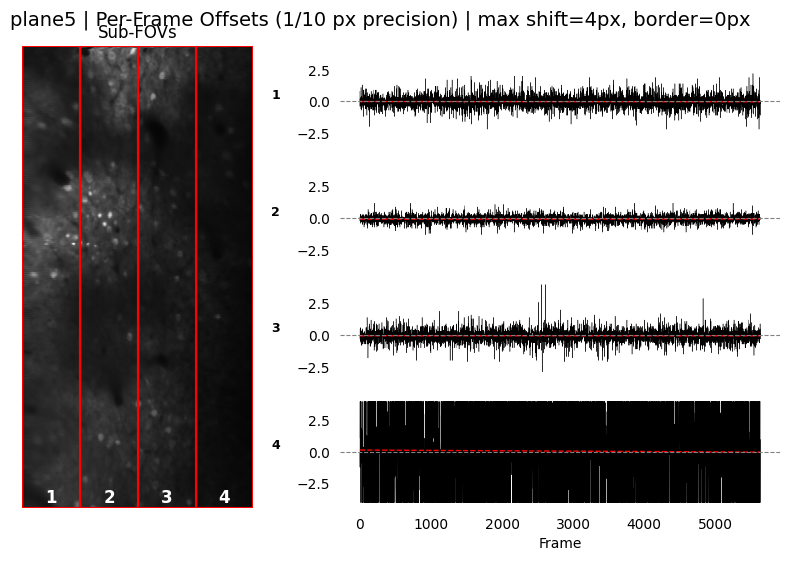

In [192]:
run_plot_for_plane(data_store["plane5"], "plane5", save_dir="./results", n_parts=4, upsample=10, max_offset=4, border=0)

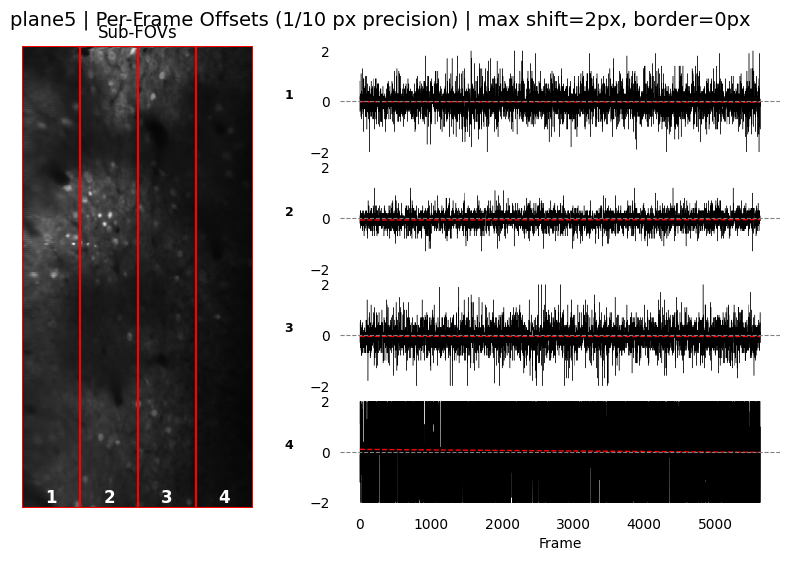

In [193]:

run_plot_for_plane(data_store["plane5"], "plane5", save_dir="./results", n_parts=4, upsample=10, max_offset=2, border=0)

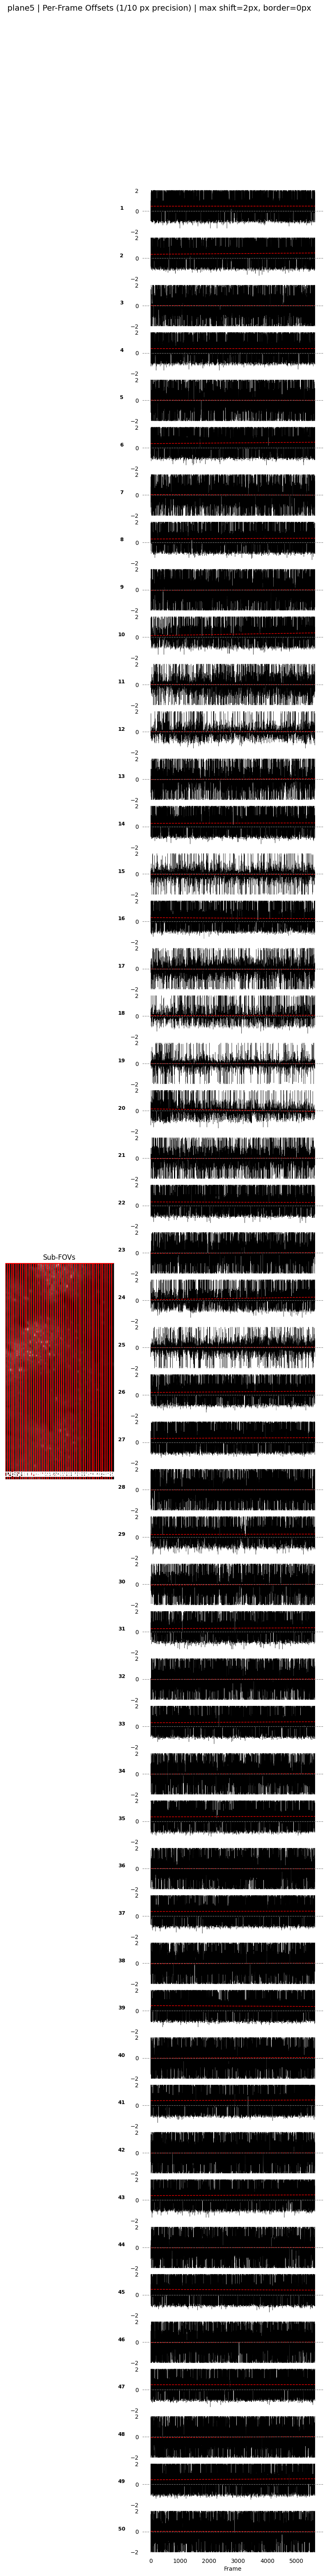

In [195]:
run_plot_for_plane(data_store["plane5"], "plane5", save_dir="./results", n_parts=50, upsample=10, max_offset=2, border=0)

Initializing MBO Scan with parameters:
roi: None, fix_phase: True, phasecorr_method: frame, border: 3, upsample: 1, max_offset: 4


Raw tiff fully read.


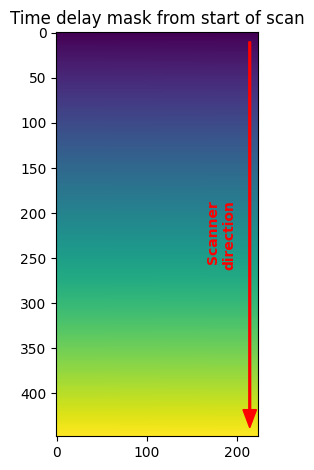

In [167]:
scan = mbo.lazy_array.LazyArrayLoader(r"D:\W2_DATA\kbarber\2025_03_01\mk301\green").load()
delay_img = scan.fields[0].offsets[1]
h, w = delay_img.shape

plt.imshow(delay_img, cmap="viridis")
plt.title("Time delay mask from start of scan")

plt.arrow(
    w - 10, 10,  
    0, h - 20,
    width=2,
    head_width=15,
    head_length=20,
    length_includes_head=True,
    color="red"
)

plt.text(
    w - 25, h // 2,
    "Scanner\ndirection",
    color="red",
    fontsize=10,
    ha="right",
    va="center",
    weight="bold",
    rotation=90
)

plt.tight_layout()
plt.show()